In [3]:
file1 = "../remote/Silicon_etch.obj"
# file1 = "../remote/Nitride_etch.obj"
file2 = "../test/initial_struct_600_600.obj"

Loaded 427622 vertices and 855240 faces from ../remote/Silicon_etch.obj
Loaded 672292 vertices and 1344580 faces from ../test/initial_struct_600_600.obj
Analyzing cross-sections...


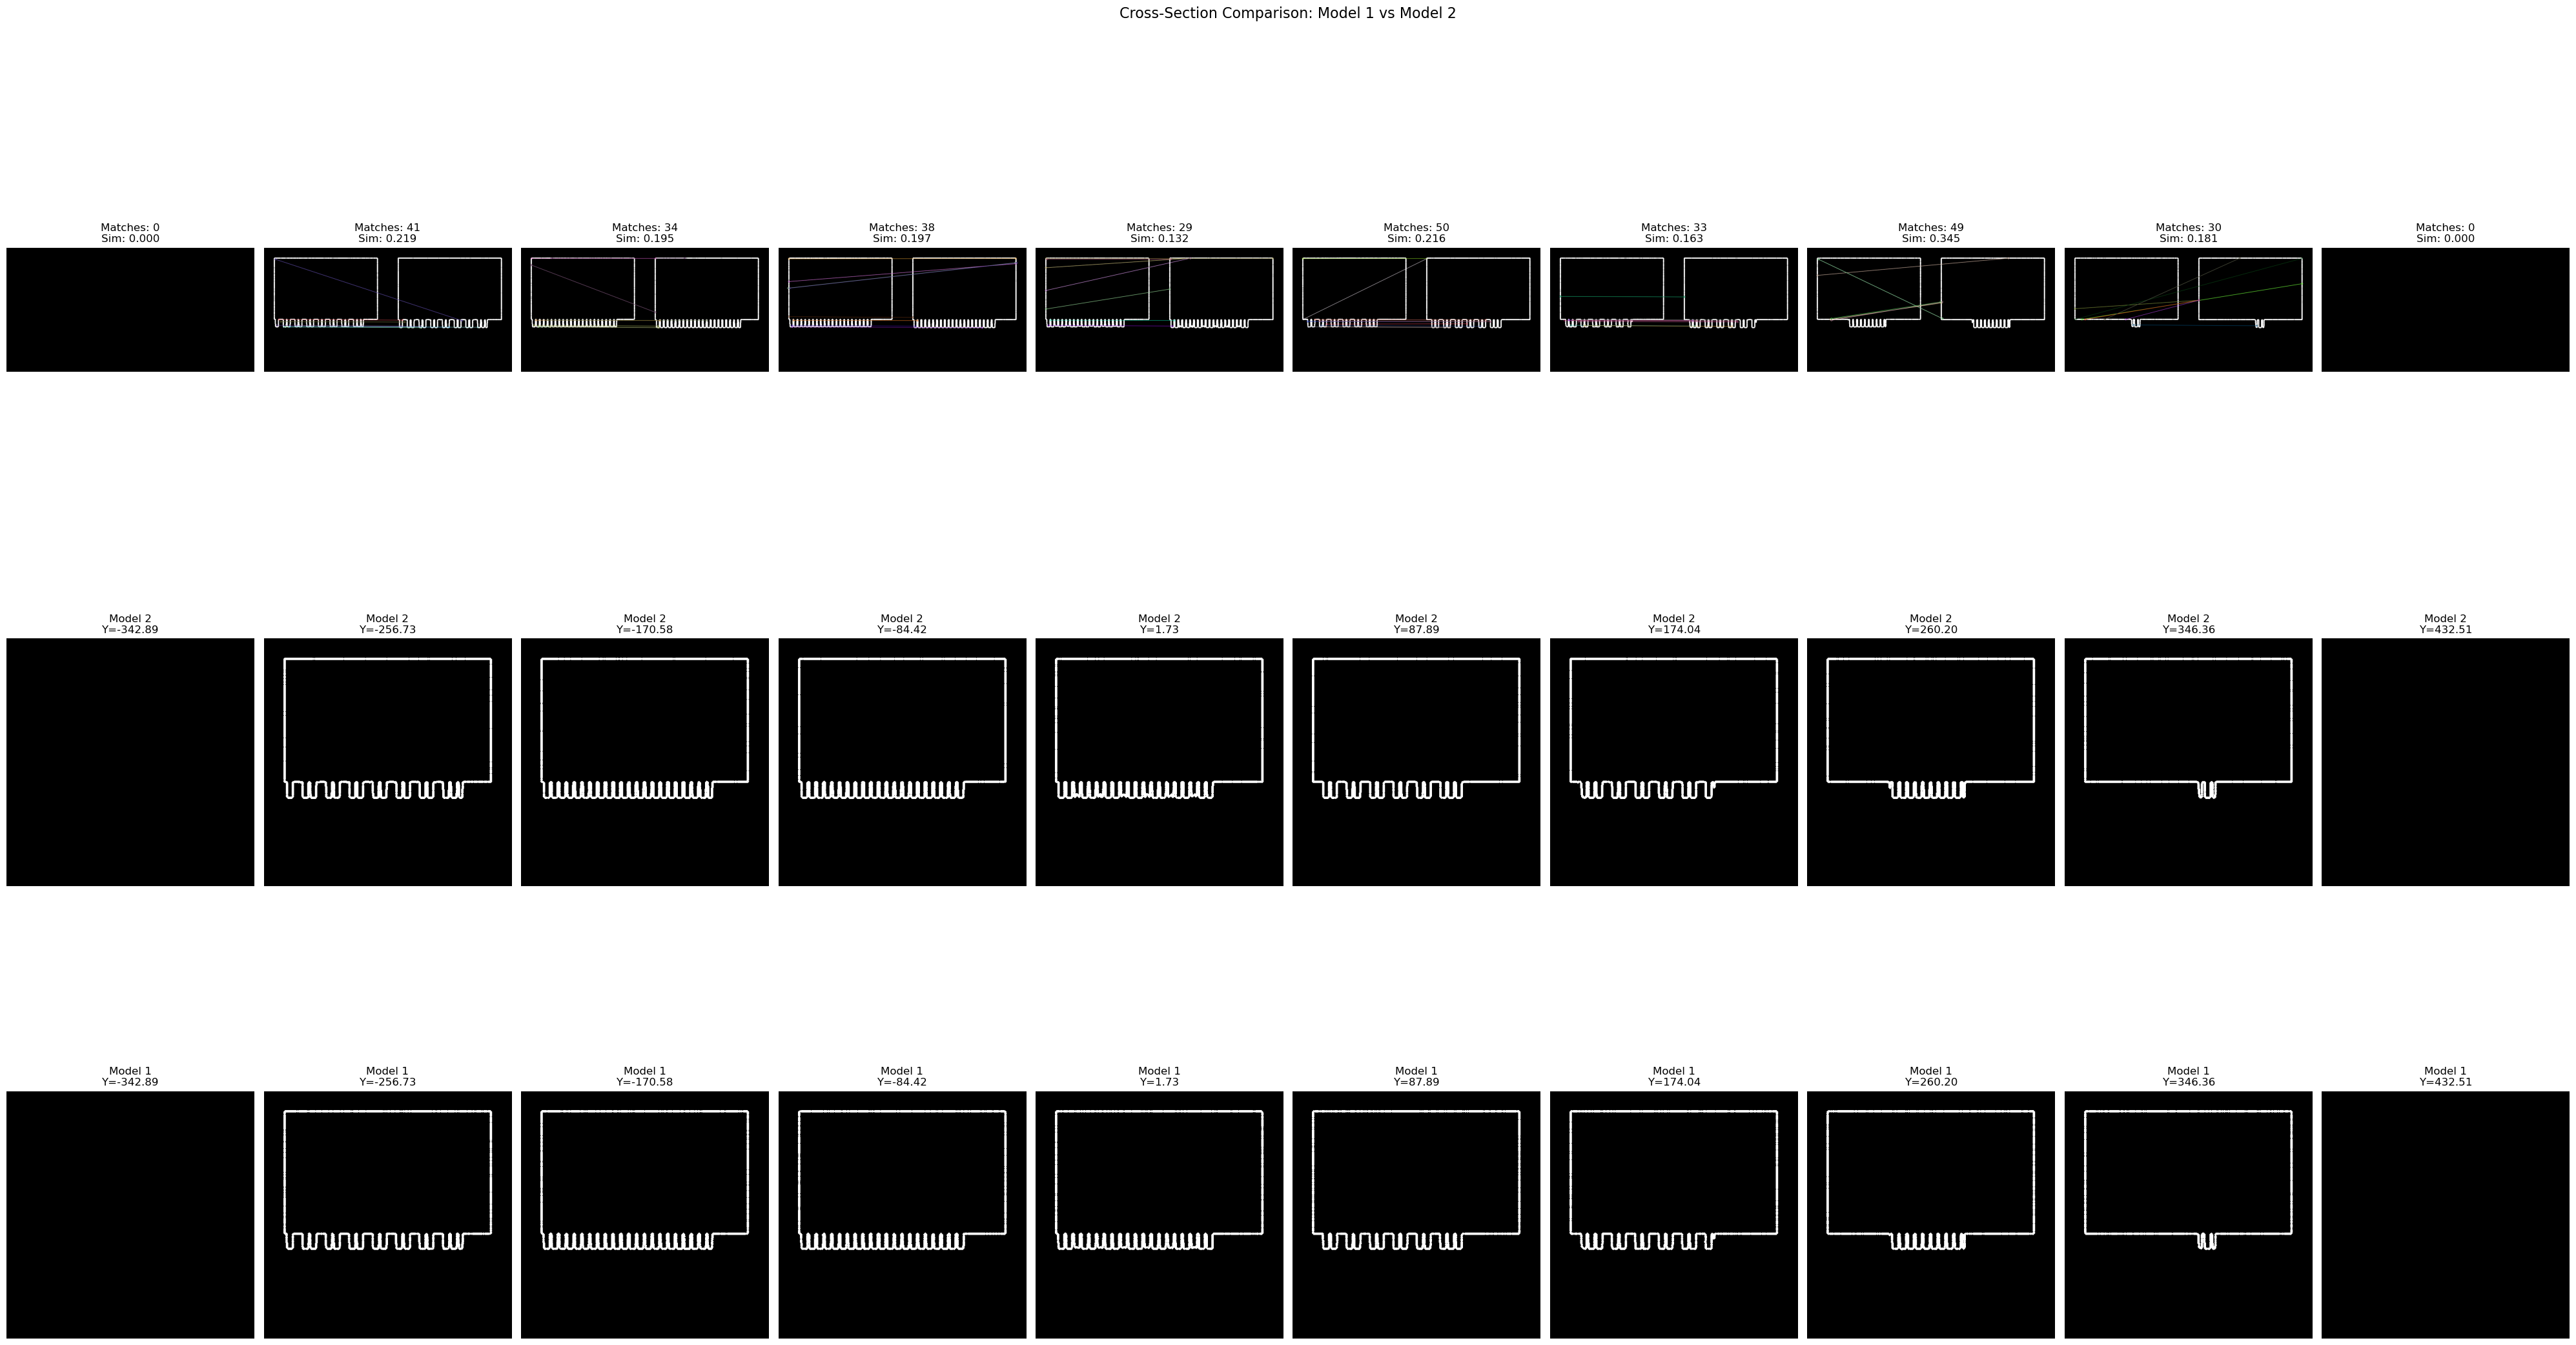

Generating similarity analysis...


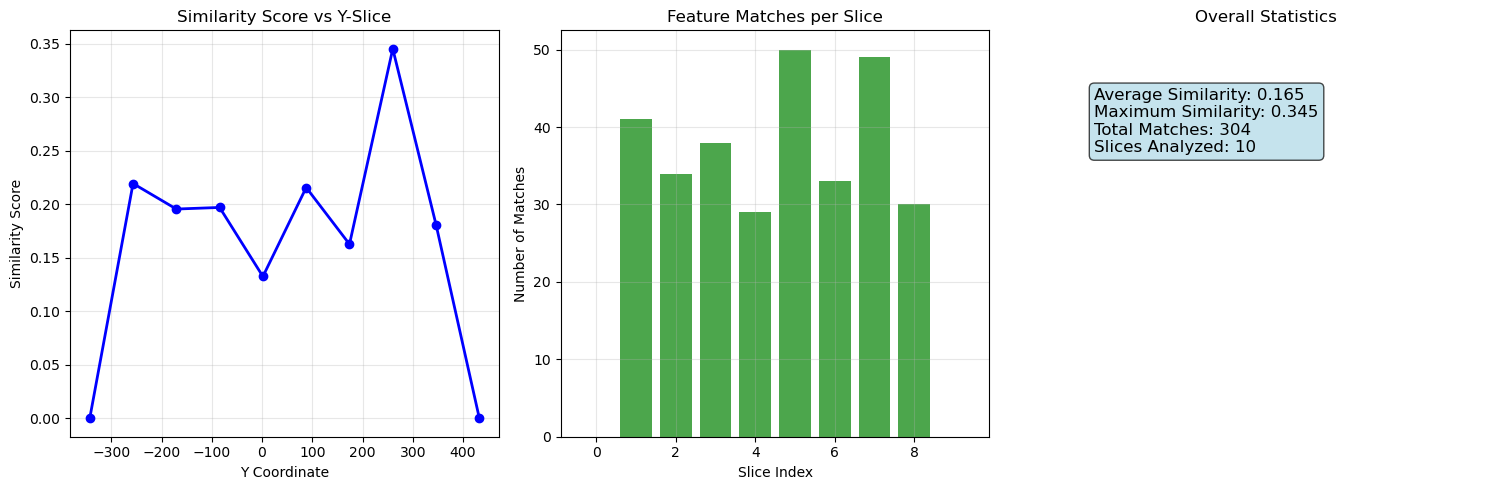


Detailed Results:
------------------------------------------------------------
Slice 1 (Y=-342.89):
  Points: 12 vs 0
  Features: 0 vs 0
  Matches: 0
  Similarity: 0.000

Slice 2 (Y=-256.73):
  Points: 6164 vs 7848
  Features: 187 vs 132
  Matches: 41
  Similarity: 0.219

Slice 3 (Y=-170.58):
  Points: 7066 vs 9194
  Features: 174 vs 122
  Matches: 34
  Similarity: 0.195

Slice 4 (Y=-84.42):
  Points: 6954 vs 8944
  Features: 193 vs 125
  Matches: 38
  Similarity: 0.197

Slice 5 (Y=1.73):
  Points: 6710 vs 8774
  Features: 219 vs 135
  Matches: 29
  Similarity: 0.132

Slice 6 (Y=87.89):
  Points: 5678 vs 7268
  Features: 232 vs 109
  Matches: 50
  Similarity: 0.216

Slice 7 (Y=174.04):
  Points: 5556 vs 7128
  Features: 203 vs 112
  Matches: 33
  Similarity: 0.163

Slice 8 (Y=260.20):
  Points: 5212 vs 6728
  Features: 142 vs 87
  Matches: 49
  Similarity: 0.345

Slice 9 (Y=346.36):
  Points: 4110 vs 5172
  Features: 166 vs 61
  Matches: 30
  Similarity: 0.181

Slice 10 (Y=432.51):
  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
import os

class OBJLoader:
    """Load and parse Wavefront .obj files"""
    
    def __init__(self, filepath):
        self.vertices = []
        self.faces = []
        self.load_obj(filepath)
    
    def load_obj(self, filepath):
        """Parse .obj file and extract vertices and faces"""
        with open(filepath, 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith('v '):  # Vertex
                    parts = line.split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    self.vertices.append(vertex)
                elif line.startswith('f '):  # Face
                    parts = line.split()
                    # Handle different face formats (v, v/vt, v/vt/vn)
                    face = []
                    for part in parts[1:]:
                        vertex_idx = int(part.split('/')[0]) - 1  # OBJ uses 1-based indexing
                        face.append(vertex_idx)
                    self.faces.append(face)
        
        self.vertices = np.array(self.vertices)
        print(f"Loaded {len(self.vertices)} vertices and {len(self.faces)} faces from {filepath}")

class CrossSectionAnalyzer:
    """Analyze cross-sections of 3D models and compare using SIFT+FLANN"""
    
    def __init__(self, obj1_path, obj2_path):
        self.model1 = OBJLoader(obj1_path)
        self.model2 = OBJLoader(obj2_path)
        self.sift = cv2.SIFT_create()
        
        # FLANN parameters
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=100)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    def get_cross_section_points(self, model, y_slice):
        """Extract cross-section points at a given Y coordinate"""
        vertices = model.vertices
        faces = model.faces
        
        cross_section_points = []
        
        # Find edges that intersect the Y plane
        for face in faces:
            if len(face) < 3:
                continue
                
            # Check each edge of the face
            for i in range(len(face)):
                v1_idx = face[i]
                v2_idx = face[(i + 1) % len(face)]
                
                if v1_idx >= len(vertices) or v2_idx >= len(vertices):
                    continue
                
                v1 = vertices[v1_idx]
                v2 = vertices[v2_idx]
                
                # Check if edge crosses the Y plane
                if (v1[1] <= y_slice <= v2[1]) or (v2[1] <= y_slice <= v1[1]):
                    if abs(v1[1] - v2[1]) > 1e-6:  # Avoid division by zero
                        # Linear interpolation to find intersection point
                        t = (y_slice - v1[1]) / (v2[1] - v1[1])
                        x = v1[0] + t * (v2[0] - v1[0])
                        z = v1[2] + t * (v2[2] - v1[2])
                        cross_section_points.append([x, z])
        
        return np.array(cross_section_points)
    
    def points_to_image(self, points, image_size=512, margin=0.1):
        """Convert 2D points to binary image"""
        if len(points) == 0:
            return np.zeros((image_size, image_size), dtype=np.uint8)
        
        # Find bounding box
        min_x, max_x = points[:, 0].min(), points[:, 0].max()
        min_z, max_z = points[:, 1].min(), points[:, 1].max()
        
        # Add margin
        range_x = max_x - min_x
        range_z = max_z - min_z
        max_range = max(range_x, range_z)
        
        if max_range == 0:
            return np.zeros((image_size, image_size), dtype=np.uint8)
        
        margin_size = max_range * margin
        
        # Create image
        image = np.zeros((image_size, image_size), dtype=np.uint8)
        
        # Map points to image coordinates
        for point in points:
            x = int((point[0] - min_x + margin_size) / (max_range + 2 * margin_size) * (image_size - 1))
            z = int((point[1] - min_z + margin_size) / (max_range + 2 * margin_size) * (image_size - 1))
            
            if 0 <= x < image_size and 0 <= z < image_size:
                # Draw a small circle around each point
                cv2.circle(image, (x, z), 2, 255, -1)
        
        return image
    
    def extract_sift_features(self, image):
        """Extract SIFT features from image"""
        keypoints, descriptors = self.sift.detectAndCompute(image, None)
        return keypoints, descriptors
    
    def match_features(self, desc1, desc2):
        """Match features using FLANN matcher"""
        if desc1 is None or desc2 is None or len(desc1) < 2 or len(desc2) < 2:
            return [], 0.0
        
        # Find matches
        matches = self.flann.knnMatch(desc1, desc2, k=2)
        
        # Apply Lowe's ratio test
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)
        
        # Calculate similarity score
        if len(good_matches) == 0:
            similarity = 0.0
        else:
            # Normalize by the number of features in both images
            similarity = len(good_matches) / max(len(desc1), len(desc2))
        
        return good_matches, similarity
    
    def analyze_cross_sections(self, num_slices=10, visualization=True):
        """Analyze cross-sections and compare models"""
        # Get Y bounds for both models
        y_min = min(self.model1.vertices[:, 1].min(), self.model2.vertices[:, 1].min())
        y_max = max(self.model1.vertices[:, 1].max(), self.model2.vertices[:, 1].max())
        
        y_slices = np.linspace(y_min, y_max, num_slices)
        
        results = []
        
        if visualization:
            fig, axes = plt.subplots(3, num_slices, figsize=(40, 24))
            fig.suptitle('Cross-Section Comparison: Model 1 vs Model 2', fontsize=16)
        
        for i, y_slice in enumerate(y_slices):
            # Get cross-section points
            points1 = self.get_cross_section_points(self.model1, y_slice)
            points2 = self.get_cross_section_points(self.model2, y_slice)
            
            # Convert to images
            img1 = self.points_to_image(points1)
            img2 = self.points_to_image(points2)
            
            # Extract SIFT features
            kp1, desc1 = self.extract_sift_features(img1)
            kp2, desc2 = self.extract_sift_features(img2)
            
            # Match features
            matches, similarity = self.match_features(desc1, desc2)
            
            results.append({
                'y_slice': y_slice,
                'points1': len(points1),
                'points2': len(points2),
                'features1': len(kp1) if kp1 else 0,
                'features2': len(kp2) if kp2 else 0,
                'matches': len(matches),
                'similarity': similarity
            })
            
            if visualization:
                # Plot Model 1 cross-section
                axes[2, i].imshow(img1, cmap='gray')
                axes[2, i].set_title(f'Model 1\nY={y_slice:.2f}')
                axes[2, i].axis('off')
                
                # Plot Model 2 cross-section
                axes[1, i].imshow(img2, cmap='gray')
                axes[1, i].set_title(f'Model 2\nY={y_slice:.2f}')
                axes[1, i].axis('off')
                
                # Plot matches visualization
                if len(matches) > 0 and desc1 is not None and desc2 is not None:
                    # Create match visualization
                    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, 
                                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
                    axes[0, i].imshow(match_img, cmap='gray')
                else:
                    # Show both images side by side
                    combined = np.hstack([img1, img2])
                    axes[0, i].imshow(combined, cmap='gray')
                
                axes[0, i].set_title(f'Matches: {len(matches)}\nSim: {similarity:.3f}')
                axes[0, i].axis('off')
        
        if visualization:
            plt.tight_layout()
            plt.show()
        
        return results
    
    def plot_similarity_analysis(self, results):
        """Plot similarity analysis results"""
        y_slices = [r['y_slice'] for r in results]
        similarities = [r['similarity'] for r in results]
        matches = [r['matches'] for r in results]
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        # Similarity over Y slices
        ax1.plot(y_slices, similarities, 'b-o', linewidth=2, markersize=6)
        ax1.set_xlabel('Y Coordinate')
        ax1.set_ylabel('Similarity Score')
        ax1.set_title('Similarity Score vs Y-Slice')
        ax1.grid(True, alpha=0.3)
        
        # Number of matches
        ax2.bar(range(len(matches)), matches, alpha=0.7, color='green')
        ax2.set_xlabel('Slice Index')
        ax2.set_ylabel('Number of Matches')
        ax2.set_title('Feature Matches per Slice')
        ax2.grid(True, alpha=0.3)
        
        # Overall statistics
        avg_similarity = np.mean(similarities)
        max_similarity = np.max(similarities)
        total_matches = np.sum(matches)
        
        stats_text = f'Average Similarity: {avg_similarity:.3f}\n'
        stats_text += f'Maximum Similarity: {max_similarity:.3f}\n'
        stats_text += f'Total Matches: {total_matches}\n'
        stats_text += f'Slices Analyzed: {len(results)}'
        
        ax3.text(0.1, 0.7, stats_text, transform=ax3.transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax3.set_title('Overall Statistics')
        ax3.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'average_similarity': avg_similarity,
            'max_similarity': max_similarity,
            'total_matches': total_matches
        }

# Example usage
def main():
    """Main function to demonstrate the cross-section comparison"""
    # Replace these paths with your actual .obj file paths
    obj1_path = file1  # Path to first .obj file
    obj2_path = file2  # Path to second .obj file
    
    # Check if files exist
    if not os.path.exists(obj1_path) or not os.path.exists(obj2_path):
        print("Error: Please provide valid paths to .obj files")
        print("Update the obj1_path and obj2_path variables with your file paths")
        return
    
    try:
        # Create analyzer
        analyzer = CrossSectionAnalyzer(obj1_path, obj2_path)
        
        # Analyze cross-sections
        print("Analyzing cross-sections...")
        results = analyzer.analyze_cross_sections(num_slices=10, visualization=True)
        
        # Plot similarity analysis
        print("Generating similarity analysis...")
        stats = analyzer.plot_similarity_analysis(results)
        
        # Print detailed results
        print("\nDetailed Results:")
        print("-" * 60)
        for i, result in enumerate(results):
            print(f"Slice {i+1} (Y={result['y_slice']:.2f}):")
            print(f"  Points: {result['points1']} vs {result['points2']}")
            print(f"  Features: {result['features1']} vs {result['features2']}")
            print(f"  Matches: {result['matches']}")
            print(f"  Similarity: {result['similarity']:.3f}")
            print()
        
        print(f"Overall Similarity Score: {stats['average_similarity']:.3f}")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        print("Please check your .obj file paths and formats")

if __name__ == "__main__":
    main()

Loading OBJ files...
Loaded 427622 vertices and 855240 faces
Loaded 672292 vertices and 1344580 faces
Model 1: 427622 vertices, 855240 faces
Model 2: 672292 vertices, 1344580 faces

Generating Y-direction slices...
Generated 15 slices for model 1
Generated 15 slices for model 2

Comparing contours...

Generating visualizations...


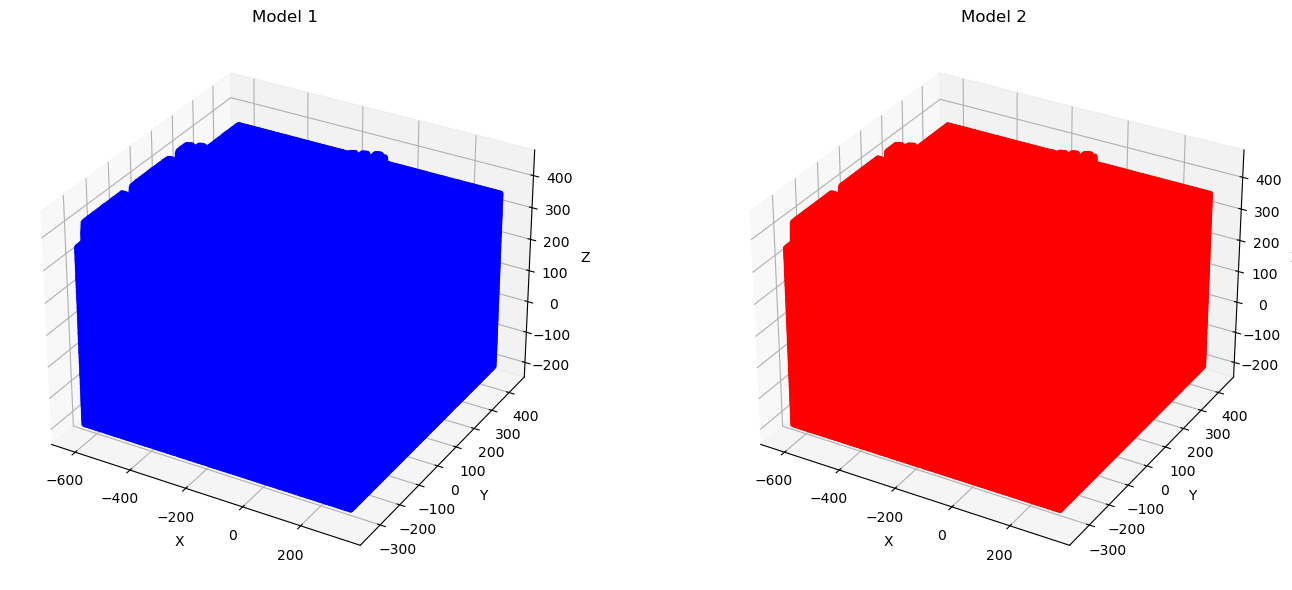

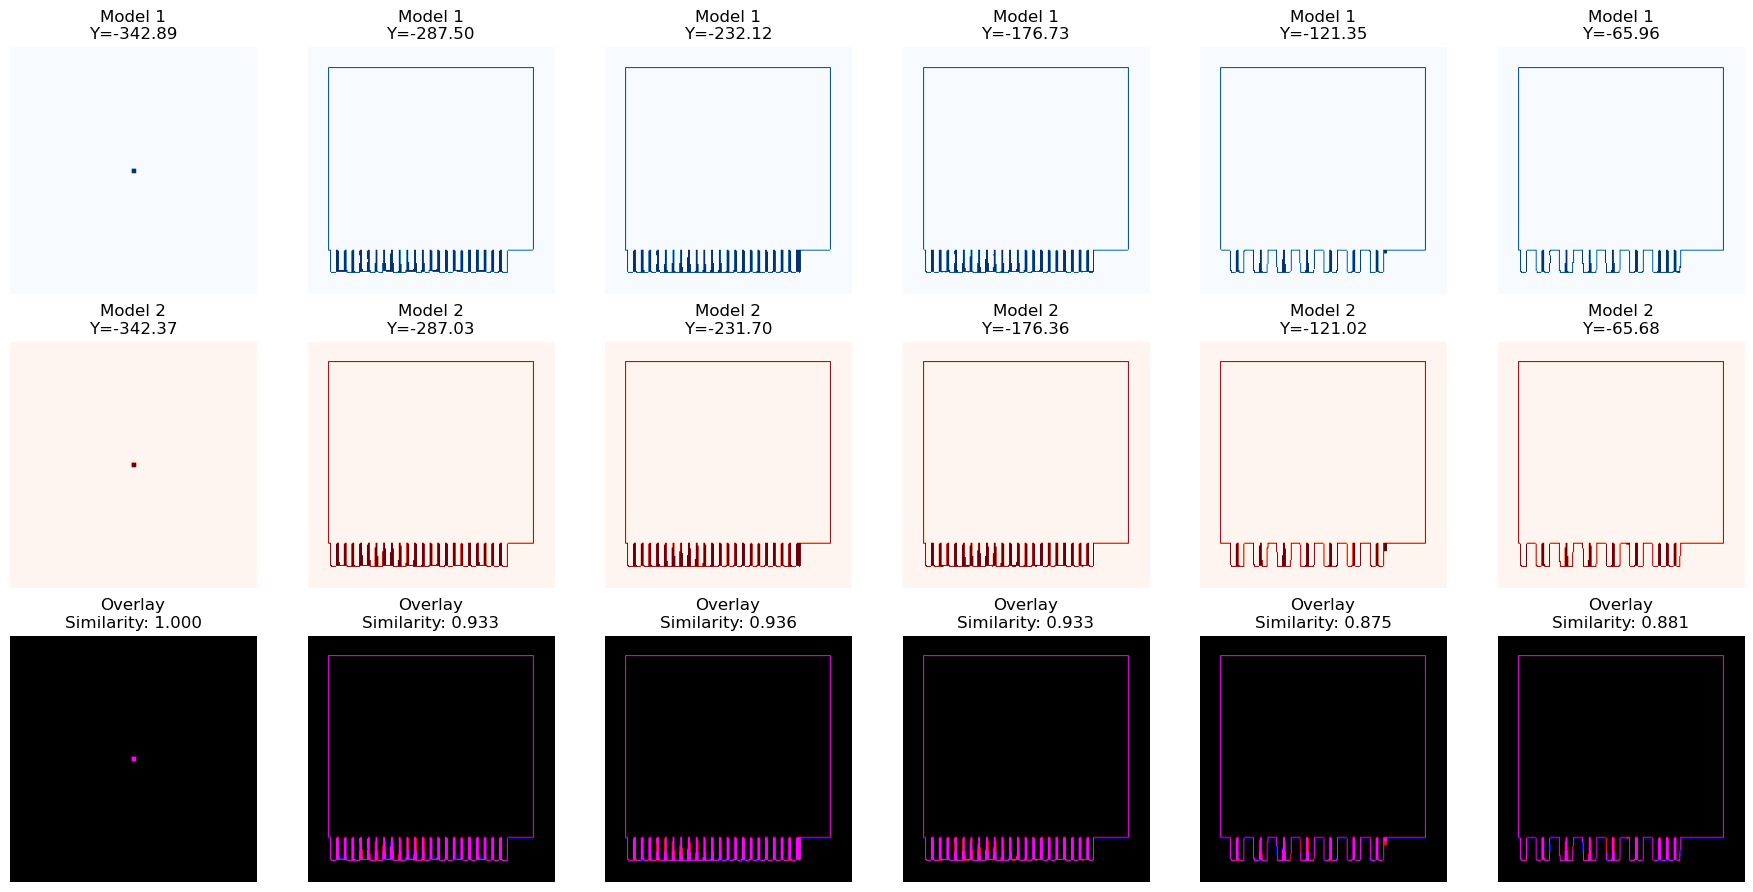

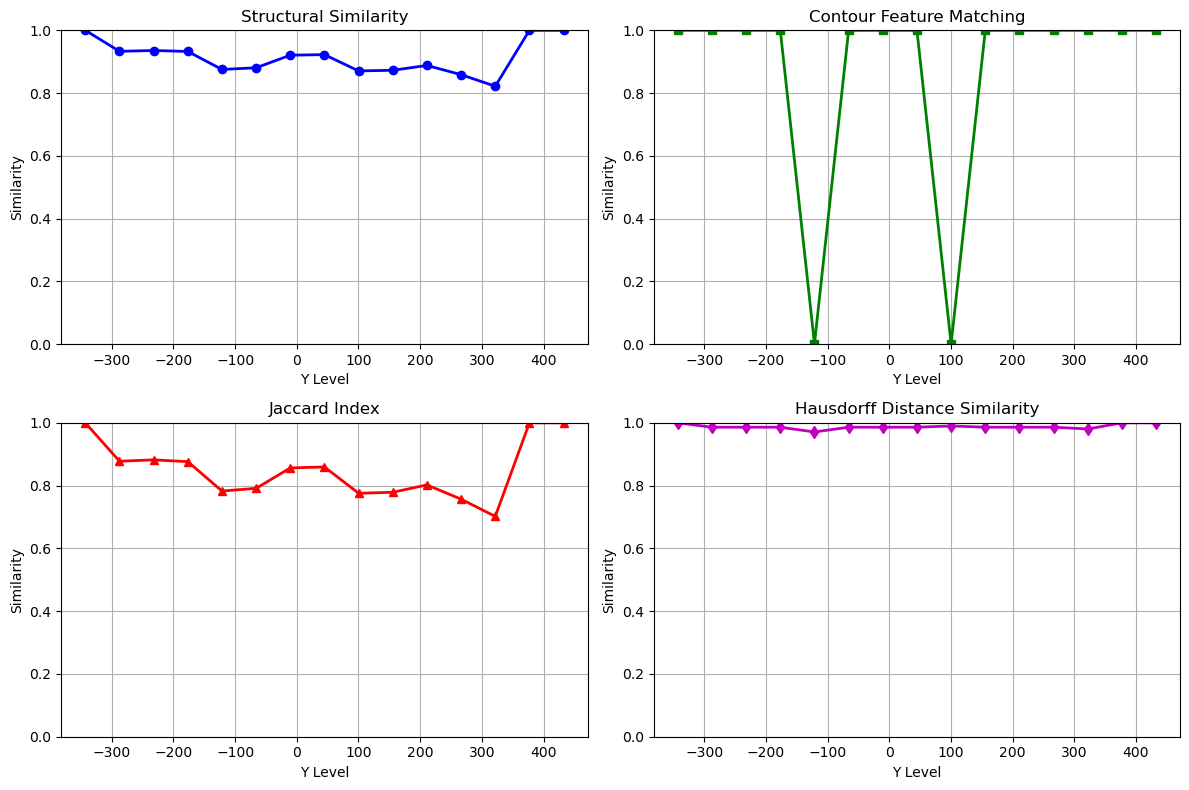


OVERALL SIMILARITY SUMMARY
Structural Similarity:     0.9142
Contour Feature Matching:  0.8668
Jaccard Index:             0.8494
Hausdorff Distance Sim:    0.9877
Average Overall Similarity: 0.9045

Analysis complete!


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from sklearn.metrics import jaccard_score
from scipy import ndimage
from scipy.spatial.distance import directed_hausdorff
import os

class OBJLoader:
    """Class to load and parse Wavefront .obj files"""
    
    def __init__(self, filepath):
        self.vertices = []
        self.faces = []
        self.load_obj(filepath)
    
    def load_obj(self, filepath):
        """Load vertices and faces from .obj file"""
        with open(filepath, 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith('v '):  # Vertex
                    parts = line.split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    self.vertices.append(vertex)
                elif line.startswith('f '):  # Face
                    parts = line.split()
                    # Handle different face formats (with or without texture/normal indices)
                    face = []
                    for part in parts[1:]:
                        vertex_idx = int(part.split('/')[0]) - 1  # .obj indices start from 1
                        face.append(vertex_idx)
                    self.faces.append(face)
        
        self.vertices = np.array(self.vertices)
        print(f"Loaded {len(self.vertices)} vertices and {len(self.faces)} faces")

class GeometryYSlicer:
    """Class to slice 3D geometry along Y-axis and extract contours"""
    
    def __init__(self, obj_loader, num_slices=20):
        self.vertices = obj_loader.vertices
        self.faces = obj_loader.faces
        self.num_slices = num_slices
        
        # Check for valid vertices
        if len(self.vertices) == 0:
            raise ValueError("No vertices found in the model")
        
        # Remove any rows with NaN or infinite values
        valid_vertices = self.vertices[np.isfinite(self.vertices).all(axis=1)]
        if len(valid_vertices) == 0:
            raise ValueError("No valid vertices found (all contain NaN or infinite values)")
        
        self.y_min = np.min(valid_vertices[:, 1])
        self.y_max = np.max(valid_vertices[:, 1])
        
        if np.isnan(self.y_min) or np.isnan(self.y_max) or self.y_min == self.y_max:
            raise ValueError("Invalid Y range in model vertices")
        
    def get_slice_contours(self):
        """Extract contours at different Y levels"""
        y_levels = np.linspace(self.y_min, self.y_max, self.num_slices)
        contours = []
        
        for y_level in y_levels:
            slice_points = self.slice_at_y(y_level)
            if len(slice_points) > 0:
                contour_image = self.points_to_image(slice_points)
                contours.append({
                    'y_level': y_level,
                    'points': slice_points,
                    'image': contour_image
                })
        
        return contours
    
    def slice_at_y(self, y_level, tolerance=0.01):
        """Find intersection points with a plane at given Y level"""
        intersection_points = []
        
        for face in self.faces:
            if len(face) < 3:
                continue
                
            # Check each edge of the face for intersection
            for i in range(len(face)):
                v1_idx = face[i]
                v2_idx = face[(i + 1) % len(face)]
                
                if v1_idx >= len(self.vertices) or v2_idx >= len(self.vertices):
                    continue
                    
                v1 = self.vertices[v1_idx]
                v2 = self.vertices[v2_idx]
                
                # Check for NaN or infinite values in vertices
                if not (np.isfinite(v1).all() and np.isfinite(v2).all()):
                    continue
                
                # Check if edge crosses the Y plane
                if (v1[1] <= y_level <= v2[1]) or (v2[1] <= y_level <= v1[1]):
                    y_diff = abs(v1[1] - v2[1])
                    if y_diff > tolerance:  # Avoid division by zero
                        # Linear interpolation to find intersection point
                        t = (y_level - v1[1]) / (v2[1] - v1[1])
                        
                        # Check if t is valid
                        if np.isfinite(t):
                            intersection_x = v1[0] + t * (v2[0] - v1[0])
                            intersection_z = v1[2] + t * (v2[2] - v1[2])
                            
                            # Check if intersection point is valid
                            if np.isfinite(intersection_x) and np.isfinite(intersection_z):
                                intersection_points.append([intersection_x, intersection_z])
        
        return np.array(intersection_points) if intersection_points else np.array([])
    
    def points_to_image(self, points, image_size=256):
        """Convert slice points to binary image for contour analysis"""
        if len(points) == 0:
            return np.zeros((image_size, image_size), dtype=np.uint8)
        
        # Remove any NaN or infinite values
        points = points[~np.isnan(points).any(axis=1)]
        points = points[np.isfinite(points).all(axis=1)]
        
        if len(points) == 0:
            return np.zeros((image_size, image_size), dtype=np.uint8)
        
        # Normalize points to image coordinates
        x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
        z_min, z_max = np.min(points[:, 1]), np.max(points[:, 1])
        
        # Check for valid ranges
        x_range = x_max - x_min
        z_range = z_max - z_min
        
        if x_range == 0 or z_range == 0 or np.isnan(x_range) or np.isnan(z_range):
            # Handle degenerate cases
            image = np.zeros((image_size, image_size), dtype=np.uint8)
            center = image_size // 2
            image[center-2:center+3, center-2:center+3] = 255
            return image
        
        # Add padding to avoid edge issues
        padding = 0.1
        x_min -= x_range * padding
        x_max += x_range * padding
        z_min -= z_range * padding
        z_max += z_range * padding
        
        # Update ranges after padding
        x_range = x_max - x_min
        z_range = z_max - z_min
        
        # Create binary image
        image = np.zeros((image_size, image_size), dtype=np.uint8)
        
        for point in points:
            if not (np.isfinite(point[0]) and np.isfinite(point[1])):
                continue
                
            x_norm_float = (point[0] - x_min) / x_range * (image_size - 1)
            z_norm_float = (point[1] - z_min) / z_range * (image_size - 1)
            
            # Check for NaN before converting to int
            if np.isnan(x_norm_float) or np.isnan(z_norm_float):
                continue
                
            x_norm = int(np.clip(x_norm_float, 0, image_size - 1))
            z_norm = int(np.clip(z_norm_float, 0, image_size - 1))
            
            image[z_norm, x_norm] = 255
        
        # Apply morphological operations to create cleaner contours
        kernel = np.ones((3, 3), np.uint8)
        image = cv2.dilate(image, kernel, iterations=1)
        image = cv2.erode(image, kernel, iterations=1)
        
        return image

class ContourComparator:
    """Class to compare contours using various similarity metrics"""
    
    def __init__(self):
        pass
    
    def compare_contours(self, contours1, contours2):
        """Compare two sets of contours and return similarity metrics"""
        min_length = min(len(contours1), len(contours2))
        similarities = []
        
        for i in range(min_length):
            img1 = contours1[i]['image']
            img2 = contours2[i]['image']
            
            # Calculate multiple similarity metrics
            similarity = {
                'y_level': contours1[i]['y_level'],
                'structural_similarity': self.structural_similarity(img1, img2),
                'contour_matching': self.contour_feature_matching(img1, img2),
                'jaccard_index': self.jaccard_similarity(img1, img2),
                'hausdorff_distance': self.hausdorff_similarity(img1, img2)
            }
            similarities.append(similarity)
        
        return similarities
    
    def structural_similarity(self, img1, img2):
        """Calculate structural similarity using template matching"""
        if img1.shape != img2.shape:
            img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
        
        # Check if images are valid
        if img1.size == 0 or img2.size == 0:
            return 0.0
        
        # Normalize images
        img1_norm = img1.astype(np.float32) / 255.0
        img2_norm = img2.astype(np.float32) / 255.0
        
        # Check for all-zero images
        if np.sum(img1_norm) == 0 and np.sum(img2_norm) == 0:
            return 1.0  # Both are empty
        elif np.sum(img1_norm) == 0 or np.sum(img2_norm) == 0:
            return 0.0  # One is empty
        
        # Calculate correlation coefficient
        try:
            correlation = cv2.matchTemplate(img1_norm, img2_norm, cv2.TM_CCOEFF_NORMED)
            result = correlation[0, 0]
            
            # Check for NaN result
            if np.isnan(result) or not np.isfinite(result):
                return 0.0
            
            return max(0.0, min(1.0, result))  # Clamp to [0, 1]
        except:
            return 0.0
    
    def contour_feature_matching(self, img1, img2):
        """Use OpenCV feature matching for contour comparison"""
        try:
            # Find contours
            contours1, _ = cv2.findContours(img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours2, _ = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if len(contours1) == 0 or len(contours2) == 0:
                return 0.0
            
            # Get the largest contour from each image
            contour1 = max(contours1, key=cv2.contourArea)
            contour2 = max(contours2, key=cv2.contourArea)
            
            # Check if contours are valid
            if len(contour1) < 3 or len(contour2) < 3:
                return 0.0
            
            # Use Hu moments for shape comparison
            moments1 = cv2.moments(contour1)
            moments2 = cv2.moments(contour2)
            
            # Check if moments are valid
            if moments1['m00'] == 0 or moments2['m00'] == 0:
                return 0.0
            
            hu1 = cv2.HuMoments(moments1).flatten()
            hu2 = cv2.HuMoments(moments2).flatten()
            
            # Check for NaN or infinite values in Hu moments
            if not (np.isfinite(hu1).all() and np.isfinite(hu2).all()):
                return 0.0
            
            # Calculate similarity based on Hu moments
            diff = np.sum(np.abs(hu1 - hu2))
            if np.isnan(diff) or not np.isfinite(diff):
                return 0.0
            
            similarity = 1.0 / (1.0 + diff)
            return max(0.0, min(1.0, similarity))  # Clamp to [0, 1]
            
        except Exception as e:
            return 0.0
    
    def jaccard_similarity(self, img1, img2):
        """Calculate Jaccard index (Intersection over Union)"""
        if img1.shape != img2.shape:
            img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
        
        # Convert to binary
        binary1 = (img1 > 127).astype(int).flatten()
        binary2 = (img2 > 127).astype(int).flatten()
        
        intersection = np.sum(binary1 & binary2)
        union = np.sum(binary1 | binary2)
        
        if union == 0:
            return 1.0  # Both images are empty
        return intersection / union
    
    def hausdorff_similarity(self, img1, img2):
        """Calculate similarity based on Hausdorff distance"""
        try:
            # Find contour points
            points1 = np.column_stack(np.where(img1 > 127))
            points2 = np.column_stack(np.where(img2 > 127))
            
            if len(points1) == 0 or len(points2) == 0:
                return 0.0
            
            # Remove any invalid points
            points1 = points1[np.isfinite(points1).all(axis=1)]
            points2 = points2[np.isfinite(points2).all(axis=1)]
            
            if len(points1) == 0 or len(points2) == 0:
                return 0.0
            
            # Calculate Hausdorff distance
            distance1 = directed_hausdorff(points1, points2)[0]
            distance2 = directed_hausdorff(points2, points1)[0]
            
            if np.isnan(distance1) or np.isnan(distance2):
                return 0.0
            
            distance = max(distance1, distance2)
            
            # Convert to similarity (inverse relationship)
            if distance == 0:
                return 1.0
            
            similarity = 1.0 / (1.0 + distance / 100.0)  # Normalize
            return max(0.0, min(1.0, similarity))  # Clamp to [0, 1]
            
        except Exception as e:
            return 0.0

class Visualizer:
    """Class to visualize results"""
    
    def __init__(self):
        pass
    
    def plot_3d_models(self, obj1, obj2):
        """Plot both 3D models for reference"""
        fig = plt.figure(figsize=(15, 6))
        
        # Plot first model
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(obj1.vertices[:, 0], obj1.vertices[:, 1], obj1.vertices[:, 2], 
                   c='blue', alpha=0.6, s=1)
        ax1.set_title('Model 1')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        
        # Plot second model
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(obj2.vertices[:, 0], obj2.vertices[:, 1], obj2.vertices[:, 2], 
                   c='red', alpha=0.6, s=1)
        ax2.set_title('Model 2')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        
        plt.tight_layout()
        plt.show()
    
    def plot_slice_comparison(self, contours1, contours2, similarities, num_display=6):
        """Plot slice contours and their comparisons"""
        num_slices = min(len(contours1), len(contours2), num_display)
        fig, axes = plt.subplots(3, num_slices, figsize=(3*num_slices, 9))
        
        for i in range(num_slices):
            # Original contour 1
            axes[0, i].imshow(contours1[i]['image'], cmap='Blues')
            axes[0, i].set_title(f'Model 1\nY={contours1[i]["y_level"]:.2f}')
            axes[0, i].axis('off')
            
            # Original contour 2
            axes[1, i].imshow(contours2[i]['image'], cmap='Reds')
            axes[1, i].set_title(f'Model 2\nY={contours2[i]["y_level"]:.2f}')
            axes[1, i].axis('off')
            
            # Overlay comparison
            overlay = np.zeros((*contours1[i]['image'].shape, 3))
            overlay[:, :, 0] = contours2[i]['image'] / 255.0  # Red channel
            overlay[:, :, 2] = contours1[i]['image'] / 255.0  # Blue channel
            
            axes[2, i].imshow(overlay)
            sim = similarities[i]['structural_similarity']
            axes[2, i].set_title(f'Overlay\nSimilarity: {sim:.3f}')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def plot_similarity_metrics(self, similarities):
        """Plot similarity metrics over Y levels"""
        if not similarities:
            print("No similarity data to plot")
            return
            
        y_levels = [s['y_level'] for s in similarities]
        structural_sim = [s['structural_similarity'] for s in similarities]
        contour_matching = [s['contour_matching'] for s in similarities]
        jaccard_sim = [s['jaccard_index'] for s in similarities]
        hausdorff_sim = [s['hausdorff_distance'] for s in similarities]
        
        # Filter out any NaN values
        valid_indices = []
        for i in range(len(similarities)):
            if (np.isfinite(structural_sim[i]) and np.isfinite(contour_matching[i]) and 
                np.isfinite(jaccard_sim[i]) and np.isfinite(hausdorff_sim[i])):
                valid_indices.append(i)
        
        if not valid_indices:
            print("No valid similarity data to plot")
            return
        
        # Filter data to valid indices
        y_levels = [y_levels[i] for i in valid_indices]
        structural_sim = [structural_sim[i] for i in valid_indices]
        contour_matching = [contour_matching[i] for i in valid_indices]
        jaccard_sim = [jaccard_sim[i] for i in valid_indices]
        hausdorff_sim = [hausdorff_sim[i] for i in valid_indices]
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        axes[0, 0].plot(y_levels, structural_sim, 'b-o', linewidth=2)
        axes[0, 0].set_title('Structural Similarity')
        axes[0, 0].set_xlabel('Y Level')
        axes[0, 0].set_ylabel('Similarity')
        axes[0, 0].grid(True)
        axes[0, 0].set_ylim([0, 1])
        
        axes[0, 1].plot(y_levels, contour_matching, 'g-s', linewidth=2)
        axes[0, 1].set_title('Contour Feature Matching')
        axes[0, 1].set_xlabel('Y Level')
        axes[0, 1].set_ylabel('Similarity')
        axes[0, 1].grid(True)
        axes[0, 1].set_ylim([0, 1])
        
        axes[1, 0].plot(y_levels, jaccard_sim, 'r-^', linewidth=2)
        axes[1, 0].set_title('Jaccard Index')
        axes[1, 0].set_xlabel('Y Level')
        axes[1, 0].set_ylabel('Similarity')
        axes[1, 0].grid(True)
        axes[1, 0].set_ylim([0, 1])
        
        axes[1, 1].plot(y_levels, hausdorff_sim, 'm-d', linewidth=2)
        axes[1, 1].set_title('Hausdorff Distance Similarity')
        axes[1, 1].set_xlabel('Y Level')
        axes[1, 1].set_ylabel('Similarity')
        axes[1, 1].grid(True)
        axes[1, 1].set_ylim([0, 1])
        
        plt.tight_layout()
        plt.show()
        
        # Overall similarity summary
        overall_structural = np.mean(structural_sim) if structural_sim else 0.0
        overall_contour = np.mean(contour_matching) if contour_matching else 0.0
        overall_jaccard = np.mean(jaccard_sim) if jaccard_sim else 0.0
        overall_hausdorff = np.mean(hausdorff_sim) if hausdorff_sim else 0.0
        
        print("\n" + "="*50)
        print("OVERALL SIMILARITY SUMMARY")
        print("="*50)
        print(f"Structural Similarity:     {overall_structural:.4f}")
        print(f"Contour Feature Matching:  {overall_contour:.4f}")
        print(f"Jaccard Index:             {overall_jaccard:.4f}")
        print(f"Hausdorff Distance Sim:    {overall_hausdorff:.4f}")
        
        valid_scores = [s for s in [overall_structural, overall_contour, overall_jaccard, overall_hausdorff] if s > 0]
        if valid_scores:
            print(f"Average Overall Similarity: {np.mean(valid_scores):.4f}")
        else:
            print("Average Overall Similarity: 0.0000")
        print("="*50)

def main():
    """Main function to run the complete analysis"""
    # File paths - modify these to point to your .obj files
    obj_file1 = file1  # Replace with your first .obj file path
    obj_file2 = file2  # Replace with your second .obj file path
    
    print("Loading OBJ files...")
    
    # Check if files exist
    if not os.path.exists(obj_file1):
        print(f"Error: File {obj_file1} not found!")
        print("Please place your first .obj file in the current directory and name it 'model1.obj'")
        return
    
    if not os.path.exists(obj_file2):
        print(f"Error: File {obj_file2} not found!")
        print("Please place your second .obj file in the current directory and name it 'model2.obj'")
        return
    
    try:
        # Load OBJ files
        obj1 = OBJLoader(obj_file1)
        obj2 = OBJLoader(obj_file2)
        
        print(f"Model 1: {len(obj1.vertices)} vertices, {len(obj1.faces)} faces")
        print(f"Model 2: {len(obj2.vertices)} vertices, {len(obj2.faces)} faces")
        
        # Create slicers
        print("\nGenerating Y-direction slices...")
        slicer1 = GeometryYSlicer(obj1, num_slices=15)
        slicer2 = GeometryYSlicer(obj2, num_slices=15)
        
        # Extract contours
        contours1 = slicer1.get_slice_contours()
        contours2 = slicer2.get_slice_contours()
        
        print(f"Generated {len(contours1)} slices for model 1")
        print(f"Generated {len(contours2)} slices for model 2")
        
        # Compare contours
        print("\nComparing contours...")
        comparator = ContourComparator()
        similarities = comparator.compare_contours(contours1, contours2)
        
        # Visualize results
        print("\nGenerating visualizations...")
        visualizer = Visualizer()
        
        # Plot 3D models
        visualizer.plot_3d_models(obj1, obj2)
        
        # Plot slice comparisons
        visualizer.plot_slice_comparison(contours1, contours2, similarities)
        
        # Plot similarity metrics
        visualizer.plot_similarity_metrics(similarities)
        
        print("\nAnalysis complete!")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        print("Please check that your .obj files are valid and properly formatted.")

if __name__ == "__main__":
    main()